In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az

# parallel processing related
from p_tqdm import p_map
from functools import partial

#from HDDMarviz import HDDMarviz
#from InferenceDataFromHDDM import InferenceDataFromHDDM
#from plot_ppc_by_cond import plot_ppc_by_cond

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
data = pd.read_csv('/home/jovyan/hddm_data.csv', index_col=0)

In [3]:
data = data.rename(columns={'chosen_cue': 'response'})

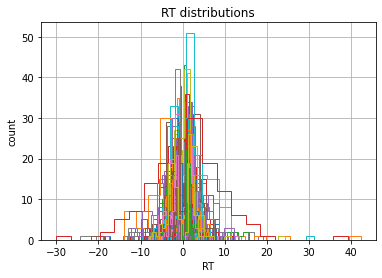

In [4]:
#flip_errors to give response value to 0 as left and 1 as right

data = hddm.utils.flip_errors(data)

#plot reaction time distribution 
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('Subj'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [5]:
data.groupby(['Subj', 'Condition']).size()

Subj  Condition
102   neutral       96
103   neutral       96
104   neutral       96
105   neutral       96
106   neutral       96
                  ... 
276   happy        128
277   sad          128
278   happy        128
279   sad          128
280   happy        128
Length: 89, dtype: int64

# Fitting a hierarchial model

In [6]:
#create a new model that estimates separate drift-rate v for the different conditions
m_stim = hddm.HDDM(data, depends_on={'v': 'Condition'})
m_stim.find_starting_values()
m_stim.sample(5000, burn=1500)

-23426.08291568048
-23426.082915679788
 [-----------------100%-----------------] 5000 of 5000 complete in 836.5 sec

In [7]:
stim_stats = m_stim.gen_stats()
stim_stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.747542,0.014652,2.718526,2.737803,2.747438,2.757258,2.776587,0.000339
v(happy),0.004704,0.012628,-0.020091,-0.003877,0.004839,0.013034,0.029558,0.000241
v(neutral),-0.022423,0.01401,-0.049428,-0.032087,-0.02242,-0.012993,0.005061,0.000236
v(sad),0.000703,0.014549,-0.027792,-0.009282,0.000559,0.010491,0.028754,0.000239
t,0.1887,0.006973,0.175143,0.183939,0.188582,0.193352,0.202709,0.000154


Plotting a
Plotting t


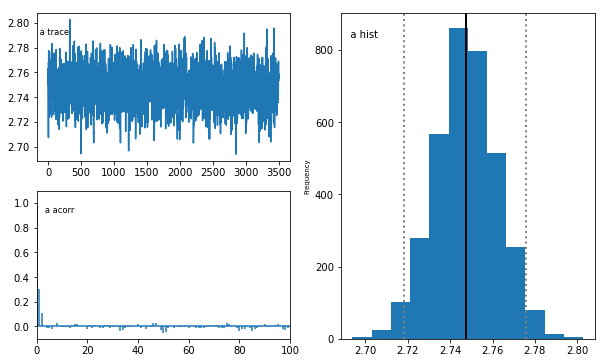

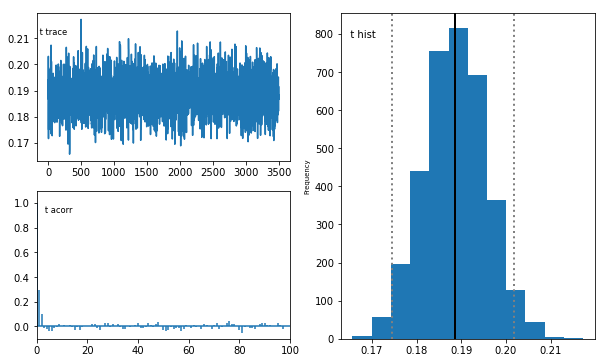

In [8]:
m_stim.plot_posteriors(['a', 'v(happy)', 'v(neutral)', 'v(sad)', 't'])

Text(0.5, 1.0, 'Posterior of drift-rate group means')

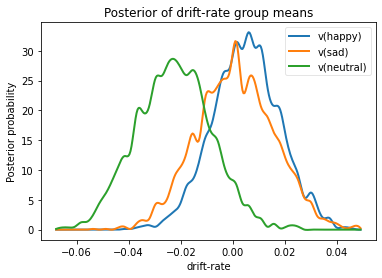

In [9]:
#how does it know which is which?
v_neutral, v_happy, v_sad = m_stim.nodes_db.node[['v(neutral)', 'v(happy)', 'v(sad)']]
hddm.analyze.plot_posterior_nodes([v_happy, v_sad, v_neutral])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')


/opt/conda/lib/python3.8/site-packages/kabuki/analyze.py:580: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(np.ceil(nrows), columns, subj_i+1)
/opt/conda/lib/python3.8/site-packages/kabuki/analyze.py:587: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')
/opt/conda/lib/python3.8/site-packages/kabuki/analyze.py:580: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(np.ceil(nrows), columns, subj_i+1)
/opt/conda/lib/python3.8/site-packages/kabuki/analyze.py:587: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')
/opt/conda/lib/python3.8/site-

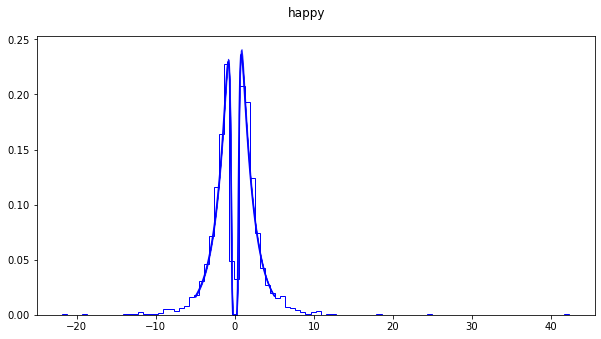

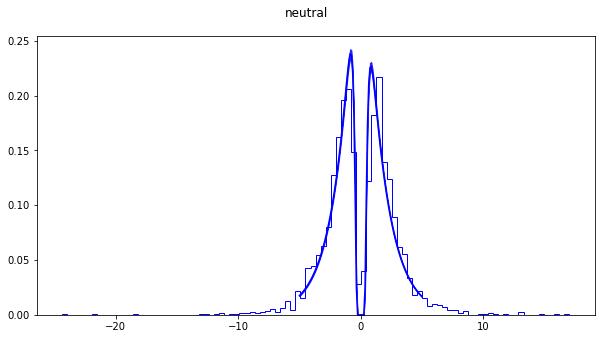

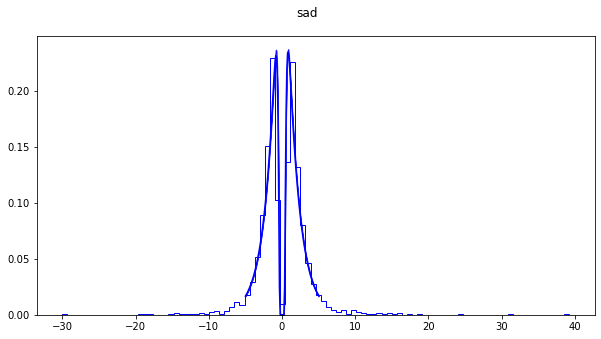

In [10]:
m_stim.plot_posterior_predictive(figsize=(10, 5))

In [11]:
#check if drift rate for happy/sad are larger than neutral - bayeasian t-test
print("P(Happy > Neutral) = ", (v_happy.trace() > v_neutral.trace()).mean())
print("P(Sad > Neutral) = ", (v_sad.trace() > v_neutral.trace()).mean())

P(Happy > Neutral) =  0.9248571428571428
P(Sad > Neutral) =  0.8768571428571429


In [35]:
#comparing models using deviance information criterion -lower is better
print("Lumped model DIC: %f" % m1.dic)
print("Stimulus model DIC: %f" % m_stim.dic)

Lumped model DIC: 33254.255404
Stimulus model DIC: 33257.765791
